In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
ratingData = pd.read_csv("ratings_Electronics.csv",sep=',', header=None)
ratingData.columns = ["userId", "productId", "Rating", "timestamp"]

In [3]:
ratingData.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


##Drop the timestamp column

In [4]:
ratingData1=ratingData.drop(['timestamp'],axis=1)
ratingData1.head(100)

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
...,...,...,...
95,A1JIOBEWHVV8MC,0594451647,5.0
96,A2OJRZGW5YVGNS,0594451647,5.0
97,A14KUMEJ094IZ3,0594451647,5.0
98,A212UCG62RO8JF,0594451647,5.0


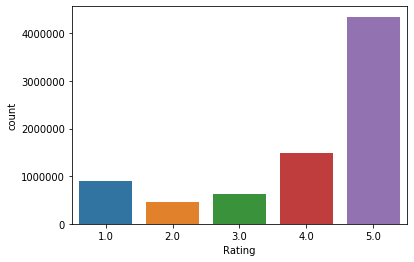

In [5]:
#plotting count of product rating
sns.countplot(data=ratingData1 , x='Rating')
#It can be seen that higher ratings are more common amongst users and rating 5 has been rated highest number of times

### EDA: Most of the ratings fall in the 4 and range.
### Next step: Pick ratings from users who have given more than 50 ratings. These ratings will be used to derive the user preferences. 

#### Step1 is to sum up the number of ratings

In [6]:
rslt_df=ratingData1
grpRatingData=rslt_df.set_index(["userId", "Rating"]).count(level="userId").sort_values('productId',ascending=False)
grpRatingData.rename(columns = {'productId': 'count'},inplace=True)

In [7]:
grpRatingData.shape

(4201696, 1)

### Fetch userid's whose count is greater than 50. (This is the only user characteristic provided, so the algorithms will predict only for these users)

In [8]:
topRankUsers=[]
for index, row in grpRatingData.iterrows(): 
    if(row['count'] >= 50):
        topRankUsers.append(index)
    else:
        break

In [9]:
# Pick all ratings provided by these users
topRankRating=rslt_df.loc[rslt_df['userId'].isin(topRankUsers)]

In [12]:
topRankRating.shape

(125871, 3)

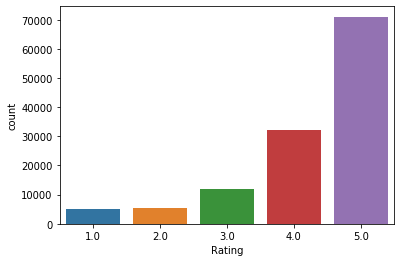

In [13]:
# Plot the number of ratings for this new dataset
sns.countplot(data=topRankRating , x='Rating')
# this plot shows that the ratio of 4 & 5 ratings is even more higher than 1,2 and 3

In [67]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(topRankRating, test_size = 0.30, random_state=0)
print(train_data.head(5))

                 userId   productId  Rating
6595853  A2BYV7S1QP2YIG  B009EAHVTA     5.0
4738241   AB094YABX21WQ  B0056XCEAA     1.0
4175596  A3D0UM4ZD2CMAW  B004I763AW     5.0
3753016   AATWFX0ZZSE6C  B0040NPHMO     3.0
1734767  A1NNMOD9H36Q8E  B0015VW3BM     4.0


In [68]:
# aggregate the products based on number of user ratings
prod_grouped = train_data.groupby(['productId']).aggregate(np.sum)

# create a ranking for the products based on number of user ratings
prod_grouped.rename(columns = {'Rating': 'score'},inplace=True)
sorted_df=prod_grouped.sort_values('score',ascending=False)

In [69]:
# Pull the top 10 ranked products as recommendation
sorted_df['Rank'] = sorted_df['score'].rank(ascending=0, method='first') 
popularity_recommendations = sorted_df.head(10) 

#In the popularity based recommendation model, all users will be given the same set of product recommendations.
popularity_recommendations

,score,Rank
productId,,
B003ES5ZUU,591.0,1.0
B007WTAJTO,575.0,2.0
B0088CJT4U,557.0,3.0
B000N99BBC,543.0,4.0
B00829THK0,434.0,5.0
B00829TIEK,431.0,6.0
B002R5AM7C,387.0,7.0
B004CLYEDC,382.0,8.0
B008DWCRQW,369.0,9.0


## Collaborative Filtering model design
    # we will use the training dataset which contains only users who have given 50 or more ratings.

In [73]:
topRankRating.shape
topRankRating.head()

,userId,productId,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [74]:
# Generate the pivot table for each movie and user combination
ratings_matrix = topRankRating.pivot(index='userId', columns='productId', values='Rating').fillna(0)
ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# perform SVD with k=50
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(ratings_matrix, k = 50)

In [76]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)

In [77]:
preds_df.head(100)

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000033,0.005506,-0.000689,0.070613,0.011499,0.000109,-0.007985,0.008121,0.004040,0.000634,...,0.000197,0.011870,0.002106,-0.037548,0.015395,-0.003956,0.002003,0.160904,-0.008435,-0.002206
96,0.010564,0.022369,-0.011650,-0.124735,0.009680,0.010282,-0.010995,0.003770,-0.004777,0.008236,...,-0.001144,-0.042478,0.017845,0.098250,-0.017741,-0.006972,0.008533,0.135594,0.022204,-0.058025
97,0.001127,0.004664,-0.000395,0.015726,0.001746,0.000283,-0.001848,-0.000644,0.002238,0.000210,...,-0.000279,0.006301,0.001144,0.005866,-0.002270,0.000187,0.003312,0.051105,0.011394,-0.004549
98,0.001330,-0.000122,0.004289,-0.001166,0.000376,0.001272,-0.000820,-0.000129,0.000215,0.001005,...,0.000018,0.000218,0.000422,-0.003381,0.001730,-0.000743,-0.000257,-0.012460,-0.002482,-0.003639


## Building collaborative filtering for user-user recommendation

In [78]:
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [79]:
# We will use the top users with > 50 ratings for deriving the user-item recommendation.
print(type(topRankRating))
topRankRating.head()

<class 'pandas.core.frame.DataFrame'>


,userId,productId,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [80]:
topRankRating.shape

(125871, 3)

In [81]:
reader = Reader(rating_scale=(1, 5))
dataSetToRate = Dataset.load_from_df(topRankRating[['userId', 'productId', 'Rating']], reader)

In [82]:
trainset1, testset1 = train_test_split(dataSetToRate, test_size=0.3)

In [83]:
#  User-based collaborative filtering
algo = KNNWithMeans(k=40, verbose=True,sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset1)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [84]:
test_pred = algo.test(testset1)

In [85]:
test_pred

[Prediction(uid='A1YEPFLLH42OU1', iid='B006TT91TW', r_ui=5.0, est=4.966190253439704, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid='A87CILADRIZW0', iid='B007CCAYIM', r_ui=5.0, est=4.263605307062843, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A11EXFO14WEJM1', iid='B003RRYAXQ', r_ui=5.0, est=3.8961725408367314, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A25HBO5V8S8SEA', iid='B0000X0VCO', r_ui=5.0, est=4.263605307062843, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A35C2IVVQR1HTK', iid='B002IO2UM2', r_ui=5.0, est=4.142857142857143, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1IU7S4HCK1XK0', iid='B003DX4IAO', r_ui=5.0, est=4.263605307062843, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1J87SYB3JPQWH', iid='B001QTXKCE', r_ui=4.0, est=4.815789473684211, details={'actual_k': 0, 

In [86]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0648


1.064823945800246

### the RMSE is showing positive, this is because the model could not predict the recommendations for many user-product combinations in the test dataset.

In [87]:
from collections import defaultdict

def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [88]:
# printing top 5 product recommendations for users in the test dataset
top_n = get_top_n(test_pred, n=5)
top_n

defaultdict(list,
            {'A1YEPFLLH42OU1': [('B00CD8ADKO', 5),
              ('B008OEHV6U', 5),
              ('B008I21EA2', 5),
              ('B003NSBF32', 5),
              ('B0037D51FQ', 5)],
             'A87CILADRIZW0': [('B005HMKKH4', 5),
              ('B001QUA6RA', 5),
              ('B000IV6S9S', 5),
              ('B005FYNSPK', 4.970851371489447),
              ('B0046HAW7Y', 4.806451612903226)],
             'A11EXFO14WEJM1': [('B006DEBYWU', 5),
              ('B001TH7T2U', 5),
              ('B000EPLP3C', 4.706182287728653),
              ('B00E87E1OM', 4.606038681938098),
              ('B000VE4PNS', 4.298245614035087)],
             'A25HBO5V8S8SEA': [('B0001A06GW', 4.946428571428571),
              ('B00004SCKA', 4.946428571428571),
              ('B0000691IO', 4.946428571428571),
              ('B0001XSK3U', 4.946428571428571),
              ('B00016L0VQ', 4.946428571428571)],
             'A35C2IVVQR1HTK': [('B00139W0XM', 4.6761904761904765),
              ('B00

## Conclusion:
    Popularity based recommendation: The recommended products are same for all users.
    
    Collaborative filtering: using the user ratings, the collaborative filtering was able to provide the top 5 item ratings for the users.